In [50]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Dense, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [88]:
df02 = pd.read_csv("C:/Users/kupa-/Downloads/daily_calendar.csv",parse_dates = ["date"])
df01= pd.read_csv("C:/Users/kupa-/Downloads/product_1005.csv",parse_dates = ["date"])
df01.head()

,date,productId,demand,promoPct
0,2023-01-01,1005,4,28.0
1,2023-01-02,1005,7,28.0
2,2023-01-03,1005,3,28.0
3,2023-01-04,1005,17,28.0
4,2023-01-05,1005,7,28.0


In [89]:
df = df01.merge(df02, on="date")
df.tail()

,date,productId,demand,promoPct,year,month,day,dow,is_weekend,season,...,holiday_names,is_ramadan,is_eid_fitr,is_eid_adha,is_valentines,is_mothers_day,is_teachers_day,is_ataturk_memorial,is_black_friday,is_back_to_school
1091,2025-12-27,1005,2,0.0,2025,12,27,5,True,winter,...,NaN,False,False,False,False,False,False,False,False,False
1092,2025-12-28,1005,3,0.0,2025,12,28,6,True,winter,...,NaN,False,False,False,False,False,False,False,False,False
1093,2025-12-29,1005,3,0.0,2025,12,29,0,False,winter,...,NaN,False,False,False,False,False,False,False,False,False
1094,2025-12-30,1005,3,0.0,2025,12,30,1,False,winter,...,NaN,False,False,False,False,False,False,False,False,False
1095,2025-12-31,1005,8,0.0,2025,12,31,2,False,winter,...,NaN,False,False,False,False,False,False,False,False,False


In [90]:
df = df.fillna(0)

In [91]:
df["is_weekend"] = df["is_weekend"].astype(int)
df["is_ramadan"] = df["is_ramadan"].astype(int)
df["is_official_holiday"] = df["is_official_holiday"].astype(int)
df["is_valentines"] = df["is_valentines"].astype(int)
df["is_mothers_day"] = df["is_mothers_day"].astype(int)
df["is_teachers_day"] = df["is_teachers_day"].astype(int)
df["is_ataturk_memorial"] = df["is_ataturk_memorial"].astype(int)
df["is_black_friday"] = df["is_black_friday"].astype(int)
df["is_back_to_school"] = df["is_back_to_school"].astype(int)
df["is_eid_fitr"] = df["is_eid_fitr"].astype(int)
df["is_eid_adha"] = df["is_eid_adha"].astype(int)
df.head()

,date,productId,demand,promoPct,year,month,day,dow,is_weekend,season,...,holiday_names,is_ramadan,is_eid_fitr,is_eid_adha,is_valentines,is_mothers_day,is_teachers_day,is_ataturk_memorial,is_black_friday,is_back_to_school
0,2023-01-01,1005,4,28.0,2023,1,1,6,1,winter,...,New Year's Day,0,0,0,0,0,0,0,0,0
1,2023-01-02,1005,7,28.0,2023,1,2,0,0,winter,...,0,0,0,0,0,0,0,0,0,0
2,2023-01-03,1005,3,28.0,2023,1,3,1,0,winter,...,0,0,0,0,0,0,0,0,0,0
3,2023-01-04,1005,17,28.0,2023,1,4,2,0,winter,...,0,0,0,0,0,0,0,0,0,0
4,2023-01-05,1005,7,28.0,2023,1,5,3,0,winter,...,0,0,0,0,0,0,0,0,0,0


In [92]:
df["is_weekend"] = df["is_weekend"].rename({"winter":1,"spring":2,"summer":3,"fall":4})

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1096 non-null   datetime64[ns]
 1   productId            1096 non-null   int64         
 2   demand               1096 non-null   int64         
 3   promoPct             1096 non-null   float64       
 4   year                 1096 non-null   int64         
 5   month                1096 non-null   int64         
 6   day                  1096 non-null   int64         
 7   dow                  1096 non-null   int64         
 8   is_weekend           1096 non-null   int64         
 9   season               1096 non-null   object        
 10  is_official_holiday  1096 non-null   int64         
 11  holiday_names        1096 non-null   object        
 12  is_ramadan           1096 non-null   int64         
 13  is_eid_fitr          1096 non-nul

In [94]:
df.drop(columns=["year","month","day"],inplace=True)

In [95]:
df.drop(columns=["season","holiday_names"], inplace = True, axis=1)

In [96]:
df["lag_1"] = df["demand"].shift(1)
df["lag_7"] = df["demand"].shift(7)
df["rolling_mean_7"] = df["demand"].shift(1).rolling(7).mean()

In [97]:
 df.dropna()

,date,productId,demand,promoPct,dow,is_weekend,is_official_holiday,is_ramadan,is_eid_fitr,is_eid_adha,is_valentines,is_mothers_day,is_teachers_day,is_ataturk_memorial,is_black_friday,is_back_to_school,lag_1,lag_7,rolling_mean_7
7,2023-01-08,1005,4,0.0,6,1,0,0,0,0,0,0,0,0,0,0,8.0,4.0,7.428571
8,2023-01-09,1005,2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,7.0,7.428571
9,2023-01-10,1005,8,0.0,1,0,0,0,0,0,0,0,0,0,0,0,2.0,3.0,6.714286
10,2023-01-11,1005,3,0.0,2,0,0,0,0,0,0,0,0,0,0,0,8.0,17.0,7.428571
11,2023-01-12,1005,9,0.0,3,0,0,0,0,0,0,0,0,0,0,0,3.0,7.0,5.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2025-12-27,1005,2,0.0,5,1,0,0,0,0,0,0,0,0,0,0,7.0,2.0,4.714286
1092,2025-12-28,1005,3,0.0,6,1,0,0,0,0,0,0,0,0,0,0,2.0,6.0,4.714286
1093,2025-12-29,1005,3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,6.0,4.285714
1094,2025-12-30,1005,3,0.0,1,0,0,0,0,0,0,0,0,0,0,0,3.0,3.0,3.857143


In [98]:
horizon = 7
targets = []
for i in range(1, horizon + 1):
    df[f"target_t+{i}"] = df["demand"].shift(-i)
    targets.append(f"target_t+{i}")

df = df.dropna()

In [99]:
x = df.drop(columns=["demand", "date"] + targets)
y = df[targets]

In [100]:
train_mask = df["date"] < (df["date"].max() - pd.Timedelta(days=30))
x_train, x_test = x[train_mask], x[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1082 entries, 7 to 1088
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1082 non-null   datetime64[ns]
 1   productId            1082 non-null   int64         
 2   demand               1082 non-null   int64         
 3   promoPct             1082 non-null   float64       
 4   dow                  1082 non-null   int64         
 5   is_weekend           1082 non-null   int64         
 6   is_official_holiday  1082 non-null   int64         
 7   is_ramadan           1082 non-null   int64         
 8   is_eid_fitr          1082 non-null   int64         
 9   is_eid_adha          1082 non-null   int64         
 10  is_valentines        1082 non-null   int64         
 11  is_mothers_day       1082 non-null   int64         
 12  is_teachers_day      1082 non-null   int64         
 13  is_ataturk_memorial  1082 non-null   i

In [102]:
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

models = {}
for i, target in enumerate(targets, start=1):
    m = model.fit(x_train, y_train[target])
    models[target] = m

In [103]:
preds = {}
for target, m in models.items():
    preds[target] = m.predict(x_test)

preds = pd.DataFrame(preds, index=x_test.index)

In [104]:
# Calculate RMSE per horizon step
for target in targets:
    rmse = np.sqrt(mean_squared_error(y_test[target], preds[target]))
    print(f"RMSE for {target}: {rmse:.2f}")

RMSE for target_t+1: 2.49
RMSE for target_t+2: 2.30
RMSE for target_t+3: 2.33
RMSE for target_t+4: 2.30
RMSE for target_t+5: 2.16
RMSE for target_t+6: 2.11
RMSE for target_t+7: 2.22


In [105]:
results = pd.concat([df.loc[x_test.index, ["date", "productId"]], y_test, preds], axis=1)
print(results.head(14))

           date  productId  target_t+1  target_t+2  target_t+3  target_t+4  \
1058 2025-11-24       1005        12.0         8.0         7.0         2.0   
1059 2025-11-25       1005         8.0         7.0         2.0         5.0   
1060 2025-11-26       1005         7.0         2.0         5.0         5.0   
1061 2025-11-27       1005         2.0         5.0         5.0         6.0   
1062 2025-11-28       1005         5.0         5.0         6.0         5.0   
1063 2025-11-29       1005         5.0         6.0         5.0         6.0   
1064 2025-11-30       1005         6.0         5.0         6.0         2.0   
1065 2025-12-01       1005         5.0         6.0         2.0         7.0   
1066 2025-12-02       1005         6.0         2.0         7.0         4.0   
1067 2025-12-03       1005         2.0         7.0         4.0         5.0   
1068 2025-12-04       1005         7.0         4.0         5.0         5.0   
1069 2025-12-05       1005         4.0         5.0         5.0  

In [107]:
print(preds.shape, preds.columns)

(31, 7) Index(['target_t+1', 'target_t+2', 'target_t+3', 'target_t+4', 'target_t+5',
       'target_t+6', 'target_t+7'],
      dtype='object')


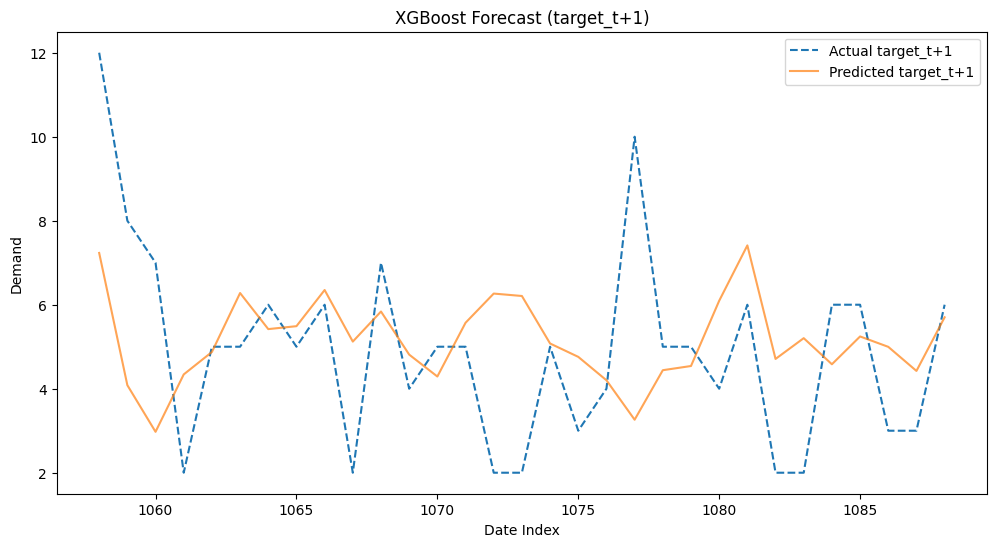

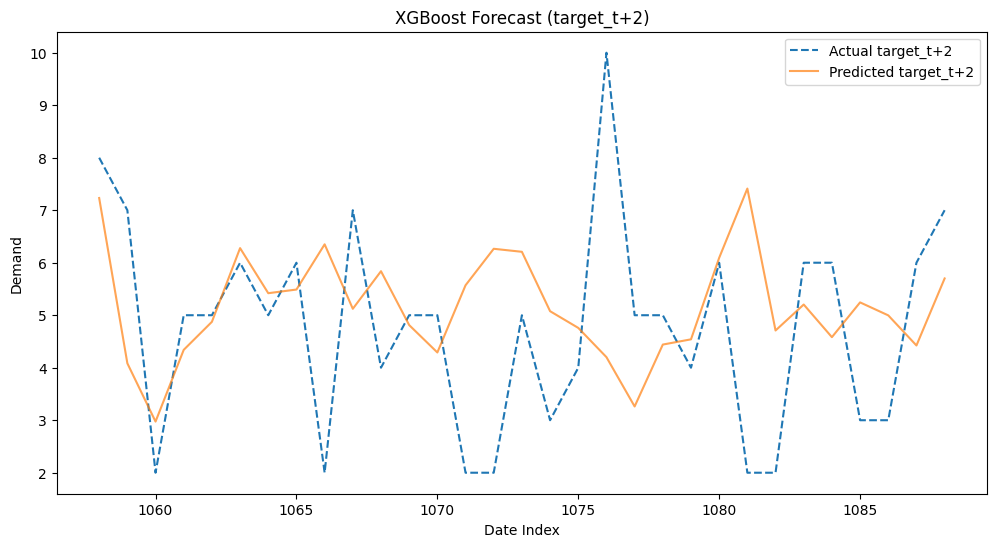

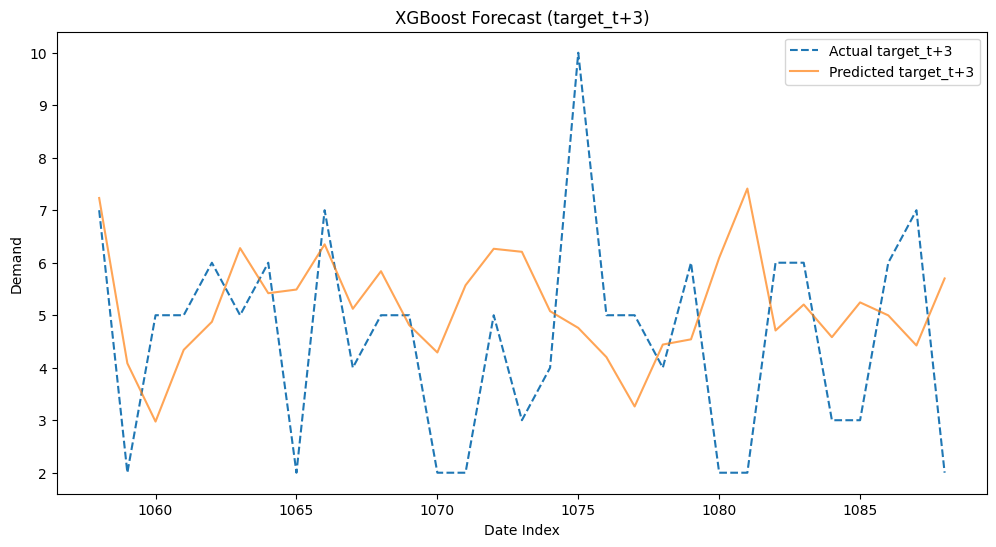

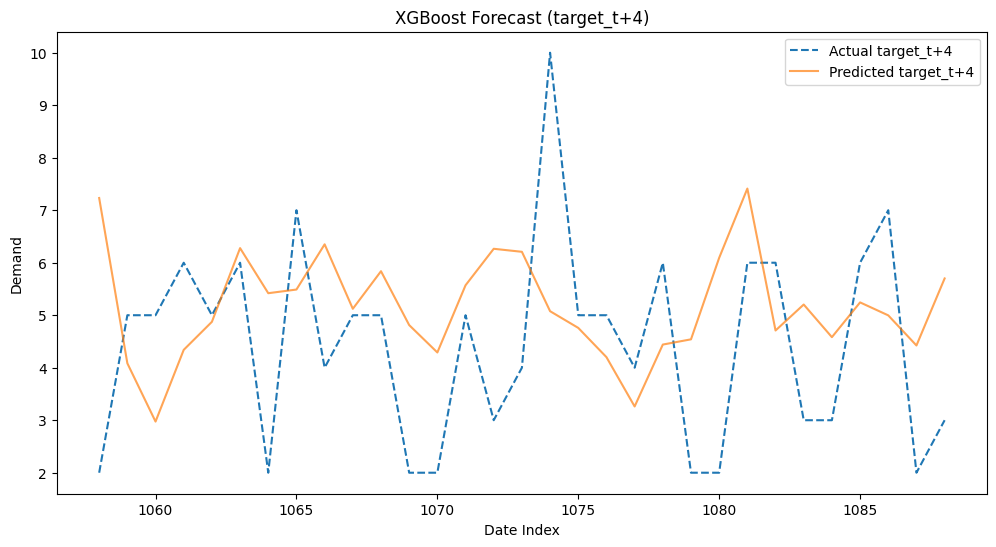

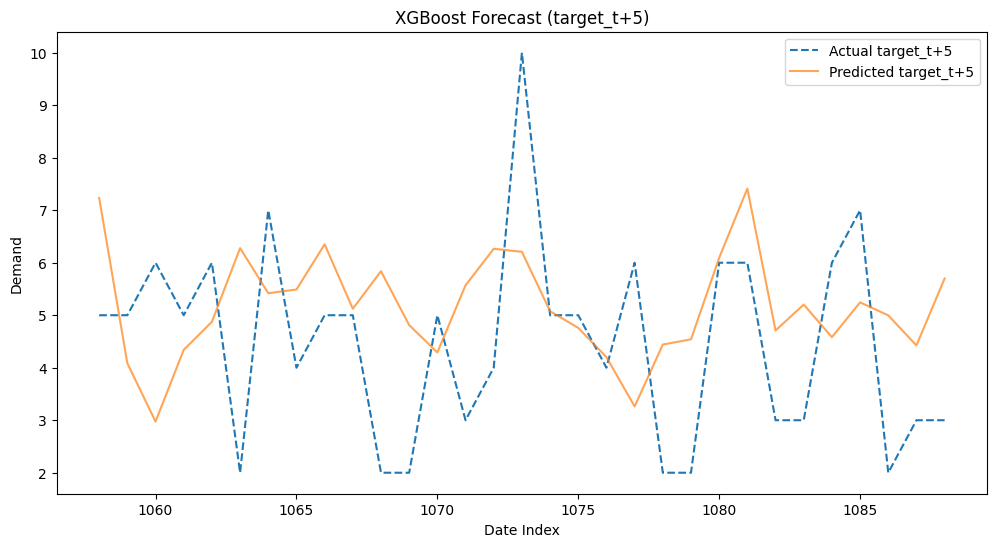

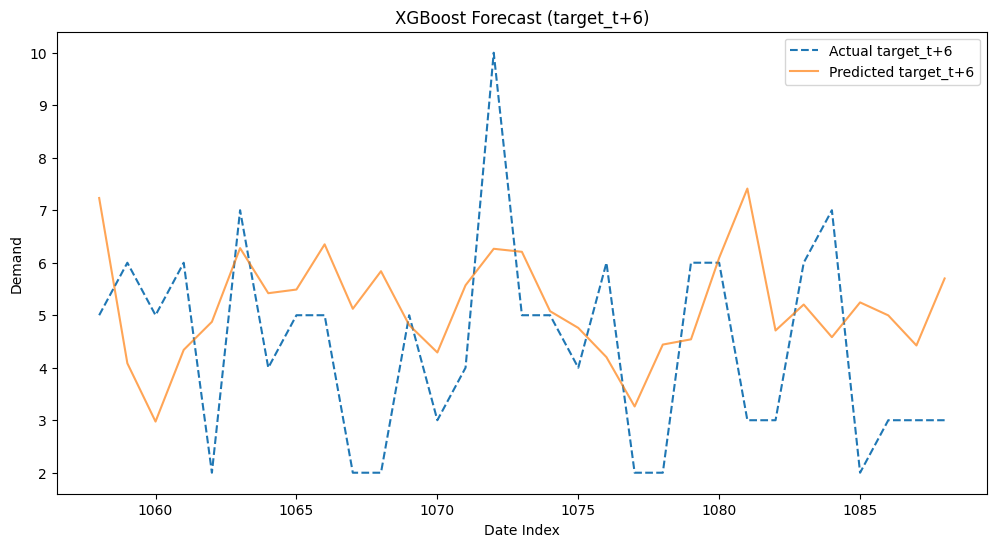

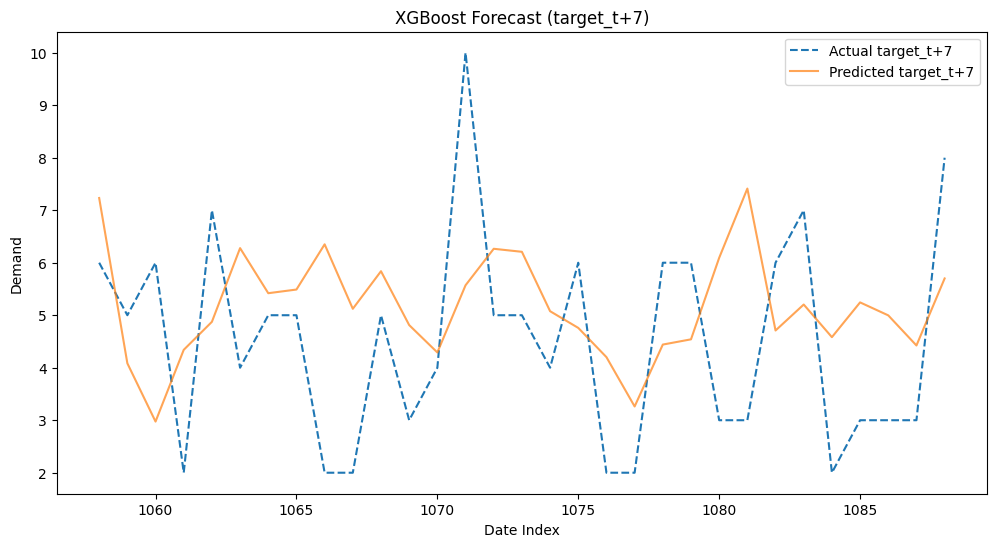

In [109]:
#7 days forecast
horizon = preds.columns  # ['target_t+1', ..., 'target_t+7']

for i, col in enumerate(horizon, start=1):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test[col], label=f'Actual {col}', linestyle='--')
    plt.plot(preds.index, preds[col], label=f'Predicted {col}', alpha=0.7)

    plt.xlabel('Date Index')
    plt.ylabel('Demand')
    plt.title(f'XGBoost Forecast ({col})')
    plt.legend()
    plt.show()

In [110]:
df.head()

,date,productId,demand,promoPct,dow,is_weekend,is_official_holiday,is_ramadan,is_eid_fitr,is_eid_adha,...,lag_1,lag_7,rolling_mean_7,target_t+1,target_t+2,target_t+3,target_t+4,target_t+5,target_t+6,target_t+7
7,2023-01-08,1005,4,0.0,6,1,0,0,0,0,...,8.0,4.0,7.428571,2.0,8.0,3.0,9.0,3.0,8.0,4.0
8,2023-01-09,1005,2,0.0,0,0,0,0,0,0,...,4.0,7.0,7.428571,8.0,3.0,9.0,3.0,8.0,4.0,7.0
9,2023-01-10,1005,8,0.0,1,0,0,0,0,0,...,2.0,3.0,6.714286,3.0,9.0,3.0,8.0,4.0,7.0,5.0
10,2023-01-11,1005,3,0.0,2,0,0,0,0,0,...,8.0,17.0,7.428571,9.0,3.0,8.0,4.0,7.0,5.0,2.0
11,2023-01-12,1005,9,0.0,3,0,0,0,0,0,...,3.0,7.0,5.428571,3.0,8.0,4.0,7.0,5.0,2.0,6.0


In [111]:
#LSTM Model
df02 = pd.read_csv("C:/Users/kupa-/Downloads/daily_calendar.csv",parse_dates = ["date"])
df01= pd.read_csv("C:/Users/kupa-/Downloads/product_1005.csv",parse_dates = ["date"])

df = df01.merge(df02, on="date")

df.fillna(0)

,date,productId,demand,promoPct,year,month,day,dow,is_weekend,season,...,holiday_names,is_ramadan,is_eid_fitr,is_eid_adha,is_valentines,is_mothers_day,is_teachers_day,is_ataturk_memorial,is_black_friday,is_back_to_school
0,2023-01-01,1005,4,28.0,2023,1,1,6,True,winter,...,New Year's Day,False,False,False,False,False,False,False,False,False
1,2023-01-02,1005,7,28.0,2023,1,2,0,False,winter,...,0,False,False,False,False,False,False,False,False,False
2,2023-01-03,1005,3,28.0,2023,1,3,1,False,winter,...,0,False,False,False,False,False,False,False,False,False
3,2023-01-04,1005,17,28.0,2023,1,4,2,False,winter,...,0,False,False,False,False,False,False,False,False,False
4,2023-01-05,1005,7,28.0,2023,1,5,3,False,winter,...,0,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2025-12-27,1005,2,0.0,2025,12,27,5,True,winter,...,0,False,False,False,False,False,False,False,False,False
1092,2025-12-28,1005,3,0.0,2025,12,28,6,True,winter,...,0,False,False,False,False,False,False,False,False,False
1093,2025-12-29,1005,3,0.0,2025,12,29,0,False,winter,...,0,False,False,False,False,False,False,False,False,False
1094,2025-12-30,1005,3,0.0,2025,12,30,1,False,winter,...,0,False,False,False,False,False,False,False,False,False


In [112]:
df["is_weekend"] = df["is_weekend"].astype(int)
df["is_ramadan"] = df["is_ramadan"].astype(int)
df["is_official_holiday"] = df["is_official_holiday"].astype(int)
df["is_valentines"] = df["is_valentines"].astype(int)
df["is_mothers_day"] = df["is_mothers_day"].astype(int)
df["is_teachers_day"] = df["is_teachers_day"].astype(int)
df["is_ataturk_memorial"] = df["is_ataturk_memorial"].astype(int)
df["is_black_friday"] = df["is_black_friday"].astype(int)
df["is_back_to_school"] = df["is_back_to_school"].astype(int)
df["is_eid_fitr"] = df["is_eid_fitr"].astype(int)
df["is_eid_adha"] = df["is_eid_adha"].astype(int)

In [113]:
df.drop(columns=["year","month","day","season","holiday_names"], inplace = True, axis=1)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1096 non-null   datetime64[ns]
 1   productId            1096 non-null   int64         
 2   demand               1096 non-null   int64         
 3   promoPct             1096 non-null   float64       
 4   dow                  1096 non-null   int64         
 5   is_weekend           1096 non-null   int64         
 6   is_official_holiday  1096 non-null   int64         
 7   is_ramadan           1096 non-null   int64         
 8   is_eid_fitr          1096 non-null   int64         
 9   is_eid_adha          1096 non-null   int64         
 10  is_valentines        1096 non-null   int64         
 11  is_mothers_day       1096 non-null   int64         
 12  is_teachers_day      1096 non-null   int64         
 13  is_ataturk_memorial  1096 non-nul

In [115]:
target = df["demand"]
exog_features = ["promoPct", "dow", "is_weekend", "is_official_holiday", 
                 "is_ramadan","is_eid_fitr","is_eid_adha","is_valentines",
                "is_mothers_day","is_teachers_day","is_ataturk_memorial",
                "is_black_friday","is_back_to_school"]
exog = df[exog_features]

In [116]:
# Split train/test (last 30 days as test)
train_target = target[:-30]
test_target = target[-30:]
train_exog = exog[:-30]
test_exog = exog[-30:]

In [117]:
model = SARIMAX(
    train_target,
    exog=train_exog,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)
print(model_fit.summary())

C:\Users\kupa-\anaconda3\envs\DeepLearning1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                            demand   No. Observations:                 1066
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2968.522
Date:                           Tue, 09 Sep 2025   AIC                           5973.044
Time:                                   08:58:09   BIC                           6062.245
Sample:                                        0   HQIC                          6006.868
                                          - 1066                                         
Covariance Type:                             opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
promoPct                0.0641      0.039      1.648      0.099      -0.012       0.140
dow             

In [118]:
#Forecast
forecast = model_fit.get_forecast(steps=30, exog=test_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [119]:
for target in targets:
    rmse = np.sqrt(mean_squared_error(test_target, forecast_mean))
    print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 2.23
Test RMSE: 2.23
Test RMSE: 2.23
Test RMSE: 2.23
Test RMSE: 2.23
Test RMSE: 2.23
Test RMSE: 2.23


In [120]:
results = pd.DataFrame({
    "actual": test_target,
    "forecast": forecast_mean
})
print(results.head(15))

      actual  forecast
1066       5  4.210602
1067       6  5.168177
1068       2  5.128091
1069       7  5.222098
1070       4  5.842833
1071       5  5.767106
1072       5  4.978123
1073       2  5.556572
1074       2  5.647719
1075       5  5.445215
1076       3  4.752896
1077       4  5.698488
1078      10  5.635632
1079       5  5.150737
1080       5  5.326704


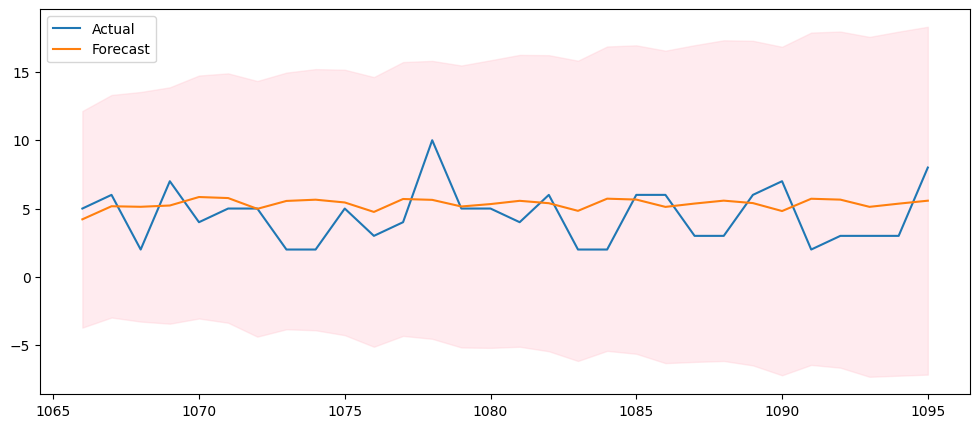

In [121]:
plt.figure(figsize=(12,5))
plt.plot(test_target.index, test_target, label="Actual")
plt.plot(test_target.index, forecast_mean, label="Forecast")
plt.fill_between(test_target.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

In [123]:
df02 = pd.read_csv("C:/Users/kupa-/Downloads/daily_calendar.csv",parse_dates = ["date"])
df01= pd.read_csv("C:/Users/kupa-/Downloads/product_1005.csv",parse_dates = ["date"])

df = df01.merge(df02, on="date")

df.fillna(0)

,date,productId,demand,promoPct,year,month,day,dow,is_weekend,season,...,holiday_names,is_ramadan,is_eid_fitr,is_eid_adha,is_valentines,is_mothers_day,is_teachers_day,is_ataturk_memorial,is_black_friday,is_back_to_school
0,2023-01-01,1005,4,28.0,2023,1,1,6,True,winter,...,New Year's Day,False,False,False,False,False,False,False,False,False
1,2023-01-02,1005,7,28.0,2023,1,2,0,False,winter,...,0,False,False,False,False,False,False,False,False,False
2,2023-01-03,1005,3,28.0,2023,1,3,1,False,winter,...,0,False,False,False,False,False,False,False,False,False
3,2023-01-04,1005,17,28.0,2023,1,4,2,False,winter,...,0,False,False,False,False,False,False,False,False,False
4,2023-01-05,1005,7,28.0,2023,1,5,3,False,winter,...,0,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2025-12-27,1005,2,0.0,2025,12,27,5,True,winter,...,0,False,False,False,False,False,False,False,False,False
1092,2025-12-28,1005,3,0.0,2025,12,28,6,True,winter,...,0,False,False,False,False,False,False,False,False,False
1093,2025-12-29,1005,3,0.0,2025,12,29,0,False,winter,...,0,False,False,False,False,False,False,False,False,False
1094,2025-12-30,1005,3,0.0,2025,12,30,1,False,winter,...,0,False,False,False,False,False,False,False,False,False


In [124]:
df["is_weekend"] = df["is_weekend"].astype(int)
df["is_ramadan"] = df["is_ramadan"].astype(int)
df["is_official_holiday"] = df["is_official_holiday"].astype(int)
df["is_valentines"] = df["is_valentines"].astype(int)
df["is_mothers_day"] = df["is_mothers_day"].astype(int)
df["is_teachers_day"] = df["is_teachers_day"].astype(int)
df["is_ataturk_memorial"] = df["is_ataturk_memorial"].astype(int)
df["is_black_friday"] = df["is_black_friday"].astype(int)
df["is_back_to_school"] = df["is_back_to_school"].astype(int)
df["is_eid_fitr"] = df["is_eid_fitr"].astype(int)
df["is_eid_adha"] = df["is_eid_adha"].astype(int)

In [125]:
df.drop(columns=["year","month","day","season","holiday_names"], inplace = True, axis=1)

In [126]:
target = "demand"
features = ["promoPct", "dow", "is_weekend","is_official_holiday", 
                 "is_ramadan","is_eid_fitr","is_eid_adha","is_valentines",
                "is_mothers_day","is_teachers_day","is_ataturk_memorial",
                "is_black_friday","is_back_to_school"]


In [128]:
#Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

In [129]:
def create_sequences(X, y, seq_length=14, horizon=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length - horizon + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length:i+seq_length+horizon])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 14  # look-back 14 days
HORIZON = 7      # predict next 7 days

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH, HORIZON)

In [130]:
# TRAIN/TEST SPLIT
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [134]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dense(HORIZON))
model.compile(optimizer='adam', loss='mse')

C:\Users\kupa-\anaconda3\envs\DeepLearning1\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [135]:
# TRAIN MODEL
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_split=0.2, verbose=1)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0185 - val_loss: 0.0132
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0081 - val_loss: 0.0114
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0075 - val_loss: 0.0122
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074 - val_loss: 0.0107
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0071 - val_loss: 0.0104
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0070 - val_loss: 0.0098
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0075 - val_loss: 0.0098
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0069 - val_loss: 0.0096
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0068 - val_loss: 0.0093
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0067 - val_loss: 0.0091
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0

In [136]:
#prediction
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, HORIZON))

y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, HORIZON))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


In [144]:
# Compute RMSE per horizon step
for i in range(HORIZON):
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    df_compare = pd.DataFrame({
        "Actual": y_test_actual[:, i],
        "Predicted": y_pred[:, i]
    })
    print(f"\nHorizon t+{i+1} | RMSE: {rmse:.2f}")
    print(df_compare.head(10))


Horizon t+1 | RMSE: 2.79
   Actual  Predicted
0     3.0   5.498753
1     4.0   5.402207
2     4.0   5.594298
3     5.0   5.865101
4    10.0   5.710468
5     4.0   5.465170
6     1.0   5.254504
7     0.0   5.352831
8     8.0   5.183979
9     8.0   5.244746

Horizon t+2 | RMSE: 2.74
   Actual  Predicted
0     4.0   4.875276
1     4.0   4.744885
2     5.0   5.101205
3    10.0   5.383874
4     4.0   5.116340
5     1.0   5.010555
6     0.0   4.970610
7     8.0   5.030895
8     8.0   4.705036
9     4.0   4.840568

Horizon t+3 | RMSE: 2.89
   Actual  Predicted
0     4.0   4.358568
1     5.0   4.882617
2    10.0   5.602283
3     4.0   5.261076
4     1.0   5.069167
5     0.0   4.938455
6     8.0   4.863884
7     8.0   4.937565
8     4.0   5.260065
9     4.0   5.457891

Horizon t+4 | RMSE: 2.80
   Actual  Predicted
0     5.0   4.861665
1    10.0   5.173493
2     4.0   5.615205
3     1.0   5.407701
4     0.0   5.374072
5     8.0   5.252471
6     8.0   5.233064
7     4.0   5.483764
8     4.0   5.

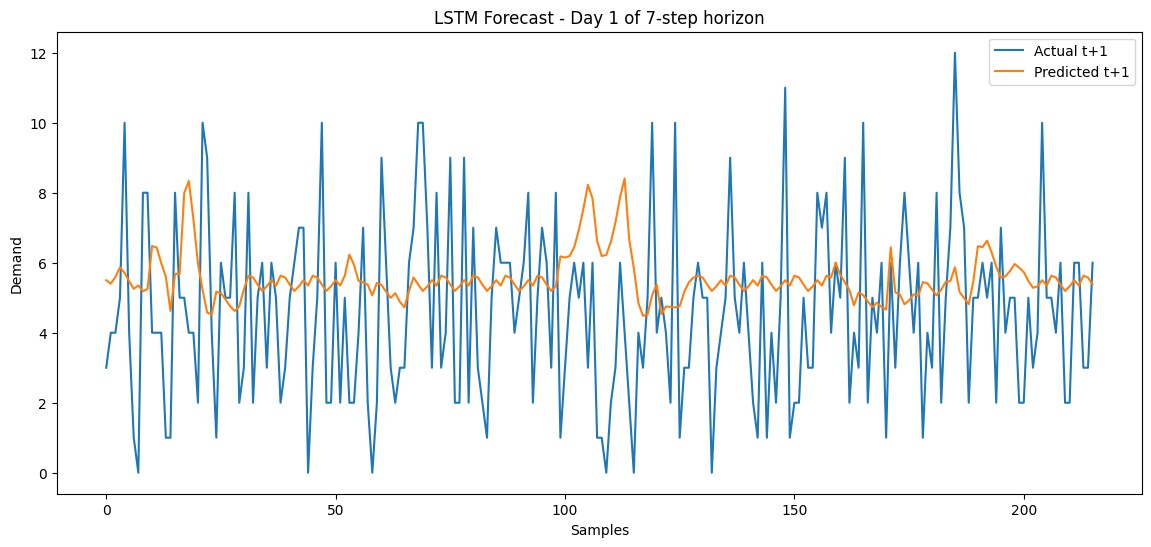

In [145]:
plt.figure(figsize=(14,6))
plt.plot(y_test_actual[:,0], label='Actual t+1')
plt.plot(y_pred[:,0], label='Predicted t+1')
plt.xlabel('Samples')
plt.ylabel('Demand')
plt.title('LSTM Forecast - Day 1 of 7-step horizon')
plt.legend()
plt.show()